<a href="https://colab.research.google.com/github/zelal-Eizaldeen/DLH-Project-Reproduce-HurtfulWords/blob/main/filtering_tokenizing_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

------------------------------------------------------------------------------
# Names:
Zilal Eiz Al Din && Payel Chakraborty
# NetIDs:
zelalae2 && payelc2
# Purpose:
 This file contains Paper Name, their Pretrained Models, Environment and Prerequisites and  Data processing.
# Dataset:
 HurtfulWordsDataset (MIMIC3)
# Paper Reference:
Hurtful Words: Quantifying Biases in Clinical Contextual Word Embeddings
 - The paper: https://arxiv.org/abs/2003.11515
 - Github Repo of the paper: https://github.com/MLforHealth/HurtfulWords
 - Github Repo of the Reproduction: https://github.com/zelal-Eizaldeen/DLH-Project-Reproduce-HurtfulWords

# Usage:
 Run `preprocessing_data` to Reads in the tables from MIMIC and pregenerates data for clinical BERT pretraining.<br>


#Resources:
- https://learning.oreilly.com/library/view/hands-on-large-language/9781098150952/ch04.html
- https://learning.oreilly.com/library/view/build-a-large/9781633437166/Text/chapter-5.html#p40
- https://learning.oreilly.com/library/view/transformers-for-natural/9781805128724/Text/Chapter_05.xhtml
- https://learning.oreilly.com/library/view/transformers-for-natural/9781805128724/Text/Chapter_03.xhtml#_idParaDest-62

# c.Model (5)
- Includes a citation to the original paper (1)
- Includes link to the original paper’s repo (if applicable)
- Includes descriptions of the model (**3_SentenceTokenization_pc**)
 - Equations and their explanations (if applicable) ->
 Log-Probabilities Calculation: For each template, the model computes the log-probability of male versus female pronouns. The comparison is made using log-likelihoods for male and female words in each sentence.

The log-probability bias score for a given template
𝑡
t can be computed as:
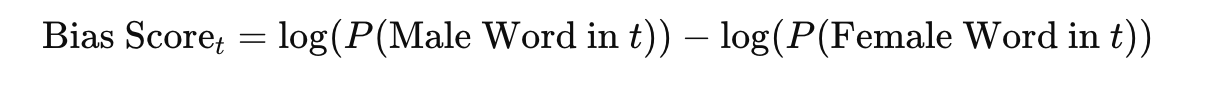

Where P(Male Word in t) is the predicted probability of a male-specific word and

P(Female Word in t) is the probability for a female-specific word.

2- After calculating the log-probability bias scores for each template sentence:

**Wilcoxon Signed-Rank Test:** This non-parametric statistical test is used to compare the mean differences in log-probability bias scores for male versus female pronouns. It tests whether the distribution of the differences in log-probabilities significantly differs between the two groups (male vs female).

Null Hypothesis: No difference in bias between male and female pronouns.

Alternative Hypothesis: A significant difference in bias (either toward male or female pronouns).


 answer is: They used **SciBERT model**.
 - Breakdown of inputs and outputs, techniques used, etc.
 -> answer: 1) They made use of **whole word masking**, 2) **replaced the PHI identifiers with special tokens denoting the identifier type**, 3) **droped outpatient notes**,

 - This is coded inside (**4_GroupSents_pc**) 4) **notes were split into sentences and tokenized using the SciBERT tokenizer**, 5) **Short sentences were aggregated with neighboring sentences into sequences of at least 20 tokens in length, to ensure that sequences fed into BERT during pretraining contain some level of semantic usefulness.**


Use LLMs to help with the implementation of the model used
What was the initial prompt that you used? What was the initial output of the LLM? Validate the LLM response. How correct, relevant, and helpful was the LLM? How many prompts did you use?
 (if applicable)
- Pretrained model: They used **Baseline_Clinical_BERT**
 - Pretrains baseline clinical BERT (initialized from SciBERT) for 1 epoch on sequences of length 128, then 1 epoch on sequences of length 512. <br> Inside **5_Pregenerate_trainingData_wrapper_pc**

and **Adversarially_Debiased_Clinical_BERT (Gender)**



In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
import json
import re
import  pandas as pd
import numpy as np
from collections import defaultdict
from scipy.stats import wilcoxon


import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import sent_tokenize


import torch
import torch.nn.functional as F


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [28]:
cleaned_one=pd.read_pickle("/content/drive/MyDrive/MastersDegree/DLH/Project/HurtfulWords/Payel-DLH-related/DataFiles/sampled_files/df_raw2.pkl")

In [4]:
len(cleaned_one)

23759

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
!nvidia-sm

/bin/bash: line 1: nvidia-sm: command not found


# Filtering the notes
1. Limit notes to the following types: 1) "Nursing"; 2) "Nursing/other"; and 3) "Physician" 4) "Discharge summary".
2. Concatenate note subsequences starting from the
end of each patient’s period of interest, working backwards, until
we reach a limit of 30 subsequences.
3. Restrict to notes within the first 48 hours of ICU stay.

In [34]:
# PATH_TO_CLEANED_RAW_DATA="/content/drive/MyDrive/MastersDegree/DLH/Project/HurtfulWords/Payel-DLH-related/DataFiles/sampled_files/df_raw2.pkl"

In [32]:
# data=pd.read_pickle(PATH_TO_CLEANED_RAW_DATA)

In [35]:
PATH_TO_CLEANED_RAW_DATA="/content/drive/MyDrive/MastersDegree/DLH/Project/HurtfulWords/Payel-DLH-related/DataFiles/sampled_files/final_raw.pkl"

In [36]:
icu_stay_df=pd.read_csv('/content/drive/MyDrive/MastersDegree/DLH/Project/HurtfulWords/Payel-DLH-related/DataFiles/mimic-iii-clinical-database-1.4/ICUSTAYS.csv')

In [37]:
# Read the data
data=pd.read_pickle(PATH_TO_CLEANED_RAW_DATA)
data = data.sample(n=23759, random_state=42)  # if you want random 5000


In [38]:
len(data)

23759

In [39]:
# Strip whitespace from the CATEGORY column
data['category'] = data['category'].str.strip()
data['category'].unique()

array(['Nursing/other', 'Nursing', 'Respiratory', 'Physician', 'Echo',
       'Radiology', 'ECG', 'Discharge summary', 'Rehab Services',
       'Nutrition', 'Case Management', 'General', 'Social Work',
       'Consult'], dtype=object)

In [40]:
# Filter note types
allowed_categories = ["Nursing", "Nursing/other", "Physician", "Discharge summary"]
data= data[data['category'].isin(allowed_categories)]

# Reset index
data = data.reset_index(drop=True)

# View the first few rows
data['category'].unique()


array(['Nursing/other', 'Nursing', 'Physician', 'Discharge summary'],
      dtype=object)

In [41]:
data['subject_id_x'] == data['subject_id_y']

,0
0,True
1,True
2,True
3,True
4,True
...,...
15868,True
15869,True
15870,True
15871,True


In [42]:
#drop one of the duplicate columns as they are always equal
data = data.drop(columns='subject_id_y')


In [43]:
data = data.rename(columns={'subject_id_x': 'subject_id'})
data.columns

Index(['row_id', 'subject_id', 'hadm_id', 'chartdate', 'charttime',
       'storetime', 'category', 'description', 'cgid', 'iserror', 'text',
       'row_id_x', 'gender', 'dob', 'dod', 'dod_hosp', 'dod_ssn',
       'expire_flag', 'fold', 'row_id_y', 'admittime', 'dischtime',
       'deathtime', 'admission_type', 'admission_location',
       'discharge_location', 'insurance', 'language', 'religion',
       'marital_status', 'ethnicity', 'edregtime', 'edouttime', 'diagnosis',
       'hospital_expire_flag', 'has_chartevents_data', 'dod_merged',
       'ethnicity_to_use', 'age', 'icd9_code', 'language_to_use',
       'icustay_id'],
      dtype='object')

In [44]:
icu_stay_df.columns=icu_stay_df.columns.str.lower()
icu_stay_df.columns

Index(['row_id', 'subject_id', 'hadm_id', 'icustay_id', 'dbsource',
       'first_careunit', 'last_careunit', 'first_wardid', 'last_wardid',
       'intime', 'outtime', 'los'],
      dtype='object')

In [45]:
# Merge notes with ICU stays on SUBJECT_ID and HADM_ID
data = pd.merge(data, icu_stay_df[['subject_id', 'hadm_id', 'icustay_id', 'intime']],
                  on=['subject_id', 'hadm_id'], how='inner')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17991 entries, 0 to 17990
Data columns (total 44 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   row_id                17991 non-null  int64         
 1   subject_id            17991 non-null  int64         
 2   hadm_id               17991 non-null  float64       
 3   chartdate             17991 non-null  datetime64[ns]
 4   charttime             17117 non-null  object        
 5   storetime             17117 non-null  object        
 6   category              17991 non-null  object        
 7   description           17991 non-null  object        
 8   cgid                  17117 non-null  float64       
 9   iserror               13 non-null     float64       
 10  text                  17991 non-null  object        
 11  row_id_x              17991 non-null  int64         
 12  gender                17991 non-null  object        
 13  dob             

let's restrict to notes within the first 48 hours of ICU stay:

In [46]:
# Convert CHARTTIME to datetime
data['charttime'] = pd.to_datetime(data['charttime'], errors='coerce')
data['intime'] = pd.to_datetime(data['intime'], errors='coerce')

In [47]:
# Calculate time difference in hours
data['hours_from_icu_admit'] = (data['charttime'] - data['intime']).dt.total_seconds() / 3600

# Keep only notes within first 48 hours
data = data[(data['hours_from_icu_admit'] >= 0) & (data['hours_from_icu_admit'] <= 48)]

# Preview
print(data.head())

     row_id  subject_id   hadm_id  chartdate           charttime  \
1    661955       44906  148560.0 2197-03-04 2197-03-04 05:48:00   
8    484577       87144  132449.0 2173-08-14 2173-08-14 03:08:00   
12  1270535         739  172752.0 2197-11-22 2197-11-22 22:38:00   
14  1553139       22210  163639.0 2119-11-26 2119-11-26 04:30:00   
18  2016227       25240  155680.0 2199-10-08 2199-10-08 16:38:00   

              storetime       category            description     cgid  \
1   2197-03-04 06:46:23        Nursing  Nursing Progress Note  19650.0   
8   2173-08-14 03:08:01        Nursing  Nursing Progress Note  20951.0   
12  2197-11-22 22:47:00  Nursing/other                 Report  18078.0   
14  2119-11-26 04:41:00  Nursing/other                 Report  19374.0   
18  2199-10-08 17:12:00  Nursing/other                 Report  16888.0   

    iserror  ... has_chartevents_data           dod_merged ethnicity_to_use  \
1       NaN  ...                    1                  NaN         

In [48]:
len(data)

4708

Concatenate up to 30 note chunks per ICU stay, starting from the latest to earliest, by following this approach:
- For each ICUSTAY_ID, you want:
1. Sorted in reverse chronological order

2. Take up to 30 notes (or fewer if less)

3. Concatenate their TEXT content into one string



In [49]:
data = data.drop(columns='icustay_id_x') # it has only none or nan values

In [50]:
data.icustay_id_y.unique()
data = data.rename(columns={'icustay_id_y': 'icustay_id'})
data.columns

Index(['row_id', 'subject_id', 'hadm_id', 'chartdate', 'charttime',
       'storetime', 'category', 'description', 'cgid', 'iserror', 'text',
       'row_id_x', 'gender', 'dob', 'dod', 'dod_hosp', 'dod_ssn',
       'expire_flag', 'fold', 'row_id_y', 'admittime', 'dischtime',
       'deathtime', 'admission_type', 'admission_location',
       'discharge_location', 'insurance', 'language', 'religion',
       'marital_status', 'ethnicity', 'edregtime', 'edouttime', 'diagnosis',
       'hospital_expire_flag', 'has_chartevents_data', 'dod_merged',
       'ethnicity_to_use', 'age', 'icd9_code', 'language_to_use', 'icustay_id',
       'intime', 'hours_from_icu_admit'],
      dtype='object')

In [51]:
# First, sort notes by ICUSTAY_ID and CHARTTIME (latest first)
notes_sorted = data.sort_values(['icustay_id', 'charttime'], ascending=[True, False])

# Group by icustay_id and collect up to 30 note texts
def concat_notes(group):
    top_notes = group.head(30)['text']  # Take top 30
    return ' '.join(str(t) for t in top_notes)  # Concatenate into one string

# Apply the function
icu_note_texts = notes_sorted.groupby('icustay_id').apply(concat_notes).reset_index()
icu_note_texts.columns = ['icustay_id', 'concat_notes']

# Preview the result
(icu_note_texts) # Each row has all the notes (up to 30) for a patient’s ICU stay, concatenated into one long string.


<ipython-input-51-30b1d7d8f845>:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  icu_note_texts = notes_sorted.groupby('icustay_id').apply(concat_notes).reset_index()


,icustay_id,concat_notes
0,200025,Respiratory Care Note\nPt received from OR int...
1,200037,NICU NPN 2300-0700\n\n\nRESP O: Baby remains i...
2,200038,84 yo M with hx of prior intraparenchymal hemo...
3,200096,1 Infant with Potential Sepsis\n2 Alt in Resp ...
4,200102,resp care\nPt initially on pcv but sats and vo...
...,...,...
4358,299883,TITLE:\n Chief Complaint:\n HPI:\n 84 yo...
4359,299907,Admission Note\nNeonatal Attending Note:\nGirl...
4360,299923,Pt was put on morphine gtt and was extubated p...
4361,299929,56 year-old man with a history of hypertension...


In [52]:
data = pd.merge(data, icu_note_texts,
                  on=['icustay_id'], how='left')

data

,row_id,subject_id,hadm_id,chartdate,charttime,storetime,category,description,cgid,iserror,...,has_chartevents_data,dod_merged,ethnicity_to_use,age,icd9_code,language_to_use,icustay_id,intime,hours_from_icu_admit,concat_notes
0,661955,44906,148560.0,2197-03-04,2197-03-04 05:48:00,2197-03-04 06:46:23,Nursing,Nursing Progress Note,19650.0,NaN,...,1,NaN,BLACK,57.0,"[7503, 53019, 53550]",English,281111,2197-03-03 21:22:19,8.428056,57 y.o. ma without significant PMHx presenting...
1,484577,87144,132449.0,2173-08-14,2173-08-14 03:08:00,2173-08-14 03:08:01,Nursing,Nursing Progress Note,20951.0,NaN,...,1,2173-08-14 14:45:00,WHITE,62.0,"[99649, 34401, 73741, 1985, V1052, 5859, 2720,...",English,204332,2173-08-12 18:34:53,32.551944,"PMH: hypothyroidism, [**2162**] left nephrecto..."
2,1270535,739,172752.0,2197-11-22,2197-11-22 22:38:00,2197-11-22 22:47:00,Nursing/other,Report,18078.0,NaN,...,1,2197-12-11 03:16:00,WHITE,60.0,"[5100, 1622, 4660, 04111, 51881, 5789, 4928, 7...",Missing,299463,2197-11-22 16:27:00,6.183333,"CTIC/SICU UPDATE NOTE\nNEURO: OFF PROPOFOL, PT..."
3,1553139,22210,163639.0,2119-11-26,2119-11-26 04:30:00,2119-11-26 04:41:00,Nursing/other,Report,19374.0,NaN,...,1,2119-11-29 02:58:00,WHITE,87.0,"[8604, 8074, 2763, 80706, 86101, E8130, 81002,...",Missing,255332,2119-11-25 14:00:57,14.484167,T/SICU RN Admit/Progress Note\nPatient s/p mvc...
4,2016227,25240,155680.0,2199-10-08,2199-10-08 16:38:00,2199-10-08 17:12:00,Nursing/other,Report,16888.0,NaN,...,1,NaN,WHITE,0.0,"[V3001, 7706, 7661, V053]",Missing,245753,2199-10-08 15:22:13,1.263056,Neonatology\nWritten on wrog patient. Disregar...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4703,469445,86402,168718.0,2159-07-02,2159-07-02 13:18:00,2159-07-02 17:39:05,Nursing,Nursing Progress Note,18240.0,NaN,...,1,2160-05-26 00:00:00,WHITE,78.0,"[41071, 49121, 42832, 41401, 40390, 5859, 2724...",English,235449,2159-07-02 11:13:08,2.081111,"Chief Complaint: Dyspnea, chest pain\n HPI:..."
4704,1881545,14362,170500.0,2127-09-03,2127-09-03 05:13:00,2127-09-03 05:27:00,Nursing/other,Report,18720.0,NaN,...,1,NaN,WHITE,0.0,"[V3000, 76527, 7793, 7742, 76519, V502, V053, ...",Missing,280854,2127-09-02 16:55:10,12.297222,NPN:\n\nRESP: Sats 97-100% in RA. Occasional ...
4705,1593817,25410,186484.0,2111-05-30,2111-05-30 17:06:00,2111-05-30 17:25:00,Nursing/other,Report,15654.0,NaN,...,1,2111-06-29 00:00:00,WHITE,84.0,"[43310, 5070, 99811, 2762, 8670, E8788, 4019, ...",Missing,291494,2111-05-29 13:38:26,27.459444,"PT SUFFERED STROKE 2 WEEKS AGO , CAME TO [**Ho..."
4706,730238,42035,140567.0,2117-04-17,2117-04-17 05:07:00,2117-04-17 07:42:33,Physician,Physician Resident Progress Note,20689.0,NaN,...,1,NaN,WHITE,81.0,"[5070, 51881, 4150, 9348, 5180, 4940, 42731, 2...",English,263483,2117-04-15 20:19:01,32.799722,Chief Complaint:\n 24 Hour Events:\n Pt ma...


#Preprocessing the notes based on the paper
1. Replace PHI placeholders with special tokens (e.g., dates
→ [DATE], names → [NAME], etc.)..
2. Drop outpatient notes

In [53]:
def is_date(string):
    string = string.lower()
    return bool(re.search(r'^\d{4}-\d{1,2}-\d{1,2}$', string) or
                re.search(r'^\d{1,2}-\d{1,2}$', string) or
                re.search(r'^\d{4}$', string) or
                re.search(r'^\d{1,2}/\d{4}$', string) or
                re.search(r'^january|february|march|april|may|june|july|august|september|october|november|december|month|year|date range', string))

def replace_deid(s):
    low_label = s.lower()
    if is_date(low_label) or 'holiday' in low_label:
        return 'PHIDATEPHI'
    elif 'hospital' in low_label:
        return 'PHIHOSPITALPHI'
    elif any(x in low_label for x in ['location', 'url', 'university', 'address', 'po box', 'state', 'country', 'company']):
        return 'PHILOCATIONPHI'
    elif any(x in low_label for x in ['name', 'dictator info', 'contact info', 'attending info']):
        return 'PHINAMEPHI'
    elif 'telephone' in low_label:
        return 'PHICONTACTPHI'
    elif any(x in low_label for x in ['job number', 'number', 'numeric identifier']) or re.search(r'^[\d\-\/]+$', low_label):
        return 'PHINUMBERPHI'
    elif 'age over 90' in low_label:
        return 'PHIAGEPHI'
    else:
        return 'PHIOTHERPHI'

def repl(match):
    s = match.group(0)
    label = s[3:-3].strip()
    return replace_deid(label)

In [54]:

def process_note_helper(note):
    # Replace PHI patterns
    regex = r'\[\*\*[^*]*\*\*\]'
    note = re.sub(regex, repl, note)

    # Clean formatting
    note = re.sub(r'\n', ' ', note)
    note = re.sub(r'[0-9]+\.', '', note)  # numbered lists
    note = re.sub(r'(-){2,}|_{2,}|={2,}', '', note)  # long underscores/dashes
    note = re.sub(r'\bdr\.', 'doctor', note, flags=re.IGNORECASE)
    note = re.sub(r'\bm\.d\.', 'md', note, flags=re.IGNORECASE)

    # Split into sentences
    note_sections = sent_tokenize(note)

    # Remove empty ones and strip
    return [s.strip() for s in note_sections if s.strip()]


In [55]:
print(nltk.data.path)


['/root/nltk_data', '/usr/nltk_data', '/usr/share/nltk_data', '/usr/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data']


In [56]:
data['cleaned_sent'] = data['concat_notes'].apply(process_note_helper)


In [57]:
example_data_note0= data['cleaned_sent'][0]
example_data_note0 #Each row in cleaned_sent will be a list of cleaned, deidentified sentences.



['57 y.o.',
 'ma without significant PMHx presenting with ?',
 'of foreign body    in his throat.',
 'The patient reported he was eating boneless sweet and    sour chicken on the evening PTA when he felt he got something caught in    his throat.',
 'Since that time, he has been unable to swallow liquids or    solids and feels as if these things get stuck in one place and comes    back up when he attempts to swallow.',
 'This is associated with pain in    his neck around the sternal notch.',
 'He denies vomiting, hematemesis, or    problems with secretions.',
 'PHINAMEPHI Problem -  ?',
 'foreign body in esophagus    Assessment:    Pt c/o inability to swallow, spits out oral secretions.',
 'Discomfort in    throat, upper chest when trying to swallow.',
 'c/o nausea, started    wretching up clear secretions a number of times.',
 'Pt was getting low    back spasms when wretching and when trying to move.',
 'SBP 130s-150s    (has not had recent health care re BP), sats 96-98 on RA, no resp

In [58]:
data['bert_input'] = data['cleaned_sent'].apply(lambda sents: ' '.join(sents))
data['bert_input'][0]

'57 y.o. ma without significant PMHx presenting with ? of foreign body    in his throat. The patient reported he was eating boneless sweet and    sour chicken on the evening PTA when he felt he got something caught in    his throat. Since that time, he has been unable to swallow liquids or    solids and feels as if these things get stuck in one place and comes    back up when he attempts to swallow. This is associated with pain in    his neck around the sternal notch. He denies vomiting, hematemesis, or    problems with secretions. PHINAMEPHI Problem -  ? foreign body in esophagus    Assessment:    Pt c/o inability to swallow, spits out oral secretions. Discomfort in    throat, upper chest when trying to swallow. c/o nausea, started    wretching up clear secretions a number of times. Pt was getting low    back spasms when wretching and when trying to move. SBP 130s-150s    (has not had recent health care re BP), sats 96-98 on RA, no resp    distress. HR 70s, nsr, no ectopy. Action:    

In [59]:
data

,row_id,subject_id,hadm_id,chartdate,charttime,storetime,category,description,cgid,iserror,...,ethnicity_to_use,age,icd9_code,language_to_use,icustay_id,intime,hours_from_icu_admit,concat_notes,cleaned_sent,bert_input
0,661955,44906,148560.0,2197-03-04,2197-03-04 05:48:00,2197-03-04 06:46:23,Nursing,Nursing Progress Note,19650.0,NaN,...,BLACK,57.0,"[7503, 53019, 53550]",English,281111,2197-03-03 21:22:19,8.428056,57 y.o. ma without significant PMHx presenting...,"[57 y.o., ma without significant PMHx presenti...",57 y.o. ma without significant PMHx presenting...
1,484577,87144,132449.0,2173-08-14,2173-08-14 03:08:00,2173-08-14 03:08:01,Nursing,Nursing Progress Note,20951.0,NaN,...,WHITE,62.0,"[99649, 34401, 73741, 1985, V1052, 5859, 2720,...",English,204332,2173-08-12 18:34:53,32.551944,"PMH: hypothyroidism, [**2162**] left nephrecto...","[PMH: hypothyroidism, PHIDATEPHI left nephrect...","PMH: hypothyroidism, PHIDATEPHI left nephrecto..."
2,1270535,739,172752.0,2197-11-22,2197-11-22 22:38:00,2197-11-22 22:47:00,Nursing/other,Report,18078.0,NaN,...,WHITE,60.0,"[5100, 1622, 4660, 04111, 51881, 5789, 4928, 7...",Missing,299463,2197-11-22 16:27:00,6.183333,"CTIC/SICU UPDATE NOTE\nNEURO: OFF PROPOFOL, PT...","[CTIC/SICU UPDATE NOTE NEURO: OFF PROPOFOL, PT...","CTIC/SICU UPDATE NOTE NEURO: OFF PROPOFOL, PT ..."
3,1553139,22210,163639.0,2119-11-26,2119-11-26 04:30:00,2119-11-26 04:41:00,Nursing/other,Report,19374.0,NaN,...,WHITE,87.0,"[8604, 8074, 2763, 80706, 86101, E8130, 81002,...",Missing,255332,2119-11-25 14:00:57,14.484167,T/SICU RN Admit/Progress Note\nPatient s/p mvc...,[T/SICU RN Admit/Progress Note Patient s/p mvc...,T/SICU RN Admit/Progress Note Patient s/p mvc ...
4,2016227,25240,155680.0,2199-10-08,2199-10-08 16:38:00,2199-10-08 17:12:00,Nursing/other,Report,16888.0,NaN,...,WHITE,0.0,"[V3001, 7706, 7661, V053]",Missing,245753,2199-10-08 15:22:13,1.263056,Neonatology\nWritten on wrog patient. Disregar...,"[Neonatology Written on wrog patient., Disrega...",Neonatology Written on wrog patient. Disregard...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4703,469445,86402,168718.0,2159-07-02,2159-07-02 13:18:00,2159-07-02 17:39:05,Nursing,Nursing Progress Note,18240.0,NaN,...,WHITE,78.0,"[41071, 49121, 42832, 41401, 40390, 5859, 2724...",English,235449,2159-07-02 11:13:08,2.081111,"Chief Complaint: Dyspnea, chest pain\n HPI:...","[Chief Complaint: Dyspnea, chest pain HPI:...","Chief Complaint: Dyspnea, chest pain HPI: ..."
4704,1881545,14362,170500.0,2127-09-03,2127-09-03 05:13:00,2127-09-03 05:27:00,Nursing/other,Report,18720.0,NaN,...,WHITE,0.0,"[V3000, 76527, 7793, 7742, 76519, V502, V053, ...",Missing,280854,2127-09-02 16:55:10,12.297222,NPN:\n\nRESP: Sats 97-100% in RA. Occasional ...,"[NPN: RESP: Sats 97-100% in RA., Occasional ...",NPN: RESP: Sats 97-100% in RA. Occasional br...
4705,1593817,25410,186484.0,2111-05-30,2111-05-30 17:06:00,2111-05-30 17:25:00,Nursing/other,Report,15654.0,NaN,...,WHITE,84.0,"[43310, 5070, 99811, 2762, 8670, E8788, 4019, ...",Missing,291494,2111-05-29 13:38:26,27.459444,"PT SUFFERED STROKE 2 WEEKS AGO , CAME TO [**Ho...","[PT SUFFERED STROKE 2 WEEKS AGO , CAME TO PHIH...","PT SUFFERED STROKE 2 WEEKS AGO , CAME TO PHIHO..."
4706,730238,42035,140567.0,2117-04-17,2117-04-17 05:07:00,2117-04-17 07:42:33,Physician,Physician Resident Progress Note,20689.0,NaN,...,WHITE,81.0,"[5070, 51881, 4150, 9348, 5180, 4940, 42731, 2...",English,263483,2117-04-15 20:19:01,32.799722,Chief Complaint:\n 24 Hour Events:\n Pt ma...,[Chief Complaint: 24 Hour Events: Pt mai...,Chief Complaint: 24 Hour Events: Pt main...


In [60]:
#Save the file after preprocessing
data.to_csv('/content/drive/MyDrive/MastersDegree/DLH/Project/HurtfulWords/Payel-DLH-related/DataFiles/cleaned_data/final_data.csv',index=False)

#BELOW is ARCHIVED CODE  Should be deleted

# Compute Log Probability Bias Scores
To calculate log probability bias scores, we compare the log probability of male (he/his) vs. female (she/her) pronouns filling in the [MASK] token in different clinical contexts.

Bias Score=logP(male word)−logP(female word)
- If Bias Score > 0 → The model favors male pronouns.

- If Bias Score < 0 → The model favors female pronouns.

- If Bias Score ≈ 0 → The model is neutral.

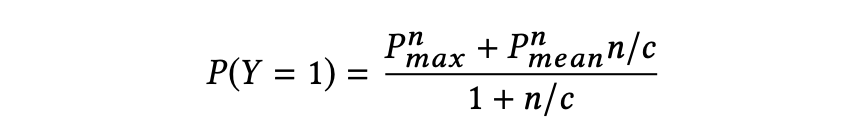

- last_hidden_state, contains the representation of all the tokens obtained only from the final encoder layer (encoder 12).
- pooler_output indicates the representation of the [CLS] token from the final encoder layer, which is further processed by a linear and tanh activation function.
- hidden_states contains the representation of all the tokens obtained from all the encoder layers.

1: Batch size (since you passed only one sentence)

512: Maximum sequence length (BERT has a max length of 512 tokens)

768: Hidden size (BERT base has 768-dimensional embeddings)

pooler_output.shape → [1, 768]

This is a pooled representation of the [CLS] token, often used for classification tasks.

hidden_states → None

Hidden states are not returned by default. You need to explicitly ask for them.

Let's explore this more. First, let's print the shape of hidden_states[0], which contains the representation of all the tokens obtained from the input embedding layer h_0:

# To implement the training described in the paper, webroke it down into two main steps:

**Train for one epoch on sequences of length 128 with a batch size of 32.**
**Train for one epoch on sequences of length 512 with a batch size of 16.**

Let’s assume you're using PyTorch and the Hugging Face Transformers library for training. Here's how you could implement it:

Step-by-Step Implementation:
Initialize the Model: We need to load the pretrained SciBERT model and tokenizer as mentioned in the previous steps.

Data Preparation: We'll need to prepare the data, tokenize it (using the SciBERT tokenizer), and pad it to the required lengths (128 and 512 tokens).

Training Loop: We'll run two separate training loops: one for training on sequences of length 128 and another for sequences of length 512.

# Preprocess the input for SciBERT


# Pretraining using SciBERT

In [ ]:
(df['BERT_sents20'][0])

['Admission Date: PHIDATEPHI\nDischarge Date: PHIDATEPHI\nDate of Birth: PHIDATEPHI\nSex: F\nService: MEDICINE\nAllergies:',
 'Macrodantin / Sulfonamides / Compazine / Atorvastatin / Lovastatin / Metoprolol',
 'Attending: PHINAMEPHI\nChief Complaint: Transfer for respiratory failure\nMajor Surgical or Invasive Procedure: PA catheter placement\nHistory of Present Illness:',
 'Ms. PHINAMEPHI is a 69 year-old female with a history of diabetes, coronary artery disease, COPD who presents on transfer for respiratory distress.',
 '.\nPer review of OSH records:  Patient presented to OSH with complaints of PHIDATEPHI days of cough and dyspnea.',
 'On the day prior to transfer, she ws out in public and experienced a sudden onset of worsened dyspnea.',
 'She asked bystanders to call EMS and by the time they arrived she was found unresponsive; did have a pulse but was cyanotic and was intubed in the field.',
 '.\nAt the OSH, initial CXR showed congestive heart failure.\nShe was given IV lasix and 

In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

# Initialize the SciBERT tokenizer and model with whole word masking
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", use_fast=True)

# Modify the tokenizer to use whole word masking
tokenizer.is_split_into_words = True  # Ensure tokenization works for whole word masking

# Initialize the SciBERT model for Masked Language Modeling (MLM)
model = AutoModelForMaskedLM.from_pretrained("allenai/scibert_scivocab_uncased",  output_hidden_states= True) #Note: set output_hidden_states = True to obtain embeddings from all the encoder layers


In [ ]:
# Loop over the 'BERT_sents20' column and tokenize each sentence
tokenized_sentences = []

for sentence in df['BERT_sents20']:
    # Tokenize the sentence
    tokens = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True, max_length=512)

    # Store the tokenized sentence (you can store the token ids or the entire encoding)
    tokenized_sentences.append(tokens)

# tokenized_sentences will now contain the tokenized form of each sentence
# You can access individual tokens like this: tokenized_sentences[0]['input_ids']
print(tokenized_sentences[:5])  # print the first 5 tokenized sentences as an example
# print(tokenized_sentences[0]['input_ids'])#This would give you a tensor of token IDs for the first sentence.

# print(tokenized_sentences[0]['attention_mask']) #This would give you a tensor of  attention_mask for the first sentence.


[{'input_ids': tensor([[  102,  7512,  4282,  ...,     0,     0,     0],
        [  102,  7183, 21095,  ...,     0,     0,     0],
        [  102, 15799,   862,  ...,     0,     0,     0],
        ...,
        [  102,  3604, 11697,  ...,     0,     0,     0],
        [  102, 19418, 15532,  ...,     0,     0,     0],
        [  102,  6950,   803,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}, {'input_ids': tensor([[  102,  7512,  4282,  ...,     0,     0,     0],
        [  102,  2999,   131,  ...,     0,     0,     0],
        [  102,  

In [ ]:
input_ids_list = []
attention_mask_list = []

for sentence in df['BERT_sents20']:
    # Tokenize the sentence
    tokens = tokenizer(sentence, return_tensors="pt", padding='max_length', truncation=True, max_length=512)

    # Collect the tokenized sentence and attention mask
    input_ids_list.append(tokens['input_ids'])
    attention_mask_list.append(tokens['attention_mask'])

# Stack the tensors along dimension 0
input_ids_tensor = torch.cat(input_ids_list, dim=0)
attention_masks_tensor = torch.cat(attention_mask_list, dim=0)

# Ensure they match in size (batch_size, seq_length)
print(f"Input IDs shape: {input_ids_tensor.shape}")
print(f"Attention Masks shape: {attention_masks_tensor.shape}")


Input IDs shape: torch.Size([14477, 512])
Attention Masks shape: torch.Size([14477, 512])


In [ ]:
# Now, let's extract the 'input_ids' and 'attention_mask'
input_ids_list = []
attention_mask_list = []

for tokenized_sentence in tokenized_sentences:
    # Extract input_ids and attention_mask
    input_ids = tokenized_sentence['input_ids']
    attention_mask = tokenized_sentence['attention_mask']

    # Append them to the lists
    input_ids_list.append(input_ids)
    attention_mask_list.append(attention_mask)

# Let's check the first few tokenized sentences
print("First 5 input_ids:", input_ids_list[:5])
print("First 5 attention masks:", attention_mask_list[:5])

First 5 input_ids: [tensor([[  102,  7512,  4282,  ...,     0,     0,     0],
        [  102,  7183, 21095,  ...,     0,     0,     0],
        [  102, 15799,   862,  ...,     0,     0,     0],
        ...,
        [  102,  3604, 11697,  ...,     0,     0,     0],
        [  102, 19418, 15532,  ...,     0,     0,     0],
        [  102,  6950,   803,  ...,     0,     0,     0]]), tensor([[  102,  7512,  4282,  ...,     0,     0,     0],
        [  102,  2999,   131,  ...,     0,     0,     0],
        [  102,   111,  1454,  ...,     0,     0,     0],
        ...,
        [  102,   191, 23118,  ...,     0,     0,     0],
        [  102, 23118, 13153,  ...,     0,     0,     0],
        [  102,   105,   862,  ...,     0,     0,     0]]), tensor([[  102,  7512,  4282,  ...,     0,     0,     0],
        [  102, 15799,   862,  ...,     0,     0,     0],
        [  102,  2999,   131,  ...,     0,     0,     0],
        ...,
        [  102,  8959,  1529,  ...,     0,     0,     0],
        [

In [ ]:
print(model(input_ids_list[0], attention_mask_list[0]))


NameError: name 'model' is not defined

In [ ]:
from torch.optim import AdamW

# from transformers import BertForSequenceClassification, AdamW
# import torch

# Initialize the model from the pretrained SciBERT
model = BertForSequenceClassification.from_pretrained("allenai/scibert_scivocab_cased", num_labels=2)

# Ensure the model is in the correct mode (training)
model.train()

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Training loop (simplified example)
epochs = 3
for epoch in range(epochs):
    for batch in dataloader:
        input_ids, attention_mask = [tensor.to(device) for tensor in batch]

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)

        # Get the logits and labels (if you have labels in your dataset)
        logits = outputs.logits

        # Compute loss if you have the labels
        labels = batch['labels'].to(device)  # assuming labels are in the batch
        loss_fn = torch.nn.CrossEntropyLoss()
        loss = loss_fn(logits, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Update weights
        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


NameError: name 'dataloader' is not defined